#Install Libraries

In [1]:
!pip install -U datasets transformers accelerate pandas pyarrow chardet nltk spacy evaluate optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==

In [ ]:
# !pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 transformers==4.44.2 evaluate

#Import Libraries

In [2]:
import torch
import re,string
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
from peft import LoraConfig, get_peft_model, TaskType
from torch.utils.data import DataLoader
import nltk
import optuna
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
print('Torch:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())

Torch: 2.8.0+cu126
CUDA available: True


#Load Dataset

In [4]:
import zipfile
zip = zipfile.ZipFile("archive.zip", 'r')
zip.extractall("/content/")
zip.close()

In [11]:
#From huggingface
# dataset = load_dataset('imdb')
# print(dataset)

#Custom
dataset = load_dataset("csv",data_files={'data':'Phishing_Email.csv'})['data']
print(dataset)

Dataset({
    features: ['Unnamed: 0', 'Email Text', 'Email Type'],
    num_rows: 18650
})


In [12]:
dataset = dataset.shuffle(seed=42).select(range(15000))
print(dataset)

Dataset({
    features: ['Unnamed: 0', 'Email Text', 'Email Type'],
    num_rows: 15000
})


In [13]:
print(dataset[0])

{'Unnamed: 0': 697, 'Email Text': 'URL: http://boingboing.net/#85490404\nDate: Not suppliedA new KPMG study concludes that the RIAA and its member companies are hurting \nthemselves by focusing on cracking down on P2P sharing instead of figuring out \nways to earn a living with it.     Media companies must put less emphasis on protecting digital content and \n    instead find ways to make money from digital music and movies if they hope \n    to beat back copyright pirates who threaten their businesses, according to \n    a study released on Wednesday from KPMG...     "They complain about the Napsters," she said, referring to the bankrupt \n    music swap site that was found to violate U.S. copyright laws. "But why do \n    the Napsters exist, because the marketplace wants them."     Steel said that if the issue "is not on boardroom table ... then that \n    boardroom has problems."  Link[1] Discuss[2] (_Thanks, Michael!_)[1] http://story.news.yahoo.com/news?tmpl=story&ncid=581&e=3&cid

In [14]:
dataset = dataset.train_test_split(seed=42, test_size=0.2)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Email Text', 'Email Type'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'Email Text', 'Email Type'],
        num_rows: 3000
    })
})


#Clean Data

In [15]:
#drop nulls and fill missing values

In [15]:
re_url=True
re_html=True
re_stopwords=False
lower=True
re_punc=False

urls = re.compile(r"(www\.\S+|https?://\S+)")
htmls = re.compile(r"(<.*?>)")
stopwords = set(stopwords.words("english")) if re_stopwords else set()
punct = str.maketrans("","",string.punctuation)

In [16]:
def clean_text(x):
  if re_url:
    x=urls.sub(" ",x)
  if re_html:
    x=htmls.sub(" ",x)
  if lower:
    x=x.lower()
  if re_stopwords:
    x= " ".join([w for w in x.split() if w not in stopwords])
  if re_punc:
    x=x.translate(punct)
  return x

In [17]:
def apply_clean(batch):
  return {"Email Text":[clean_text(x if x is not None else "") for x in batch["Email Text"]]}

In [18]:
dataset=dataset.map(apply_clean,batched=True)
print(dataset["train"][0])

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'Unnamed: 0': 7132, 'Email Text': 're : phara . macy colo ured 27 hello , vislt our great pharmac - ybymail shop and save 75 % v rava luma lenci is , man lag l mb al yother . have a good day . p . s . you will be pieasantiy surprised with our prlcess ; - ) courage . now the mischievousness that normally inhabited her fresh young doctor blood , said he . he was a short , broad man of five - and - fo heavily upon a stout ebony cane . after him , in the uniform of a who the hell may you be ? he exploded . colour and grow troubled once more . could i be guilty of that ? protested the captain . i realize t that restless spirit by which he was imbued . a set of curious the bulkheads , and there was a carved walnut sideboard laden with yielded . already bishop was moving down the line . for mr . blood we might send don diego de espinosa in a boat manned by his though it took a fortnight , blood bubbled him . he sent me and mo stately red - hulled frigate , flying the english ensign . fortune

#Tokenize

In [19]:
from huggingface_hub import notebook_login

notebook_login()

In [20]:
model_name = 'microsoft/deberta-v3-base'

In [21]:
tokenizer=AutoTokenizer.from_pretrained(model_name,use_fast=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [22]:
#max_len = 256/512 or wahtever , we used 256+128 here
max_len = 512

def tokenize(batch):
  return tokenizer(batch['Email Text'], truncation=True, max_length=max_len)

In [24]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Email Text', 'Email Type'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'Email Text', 'Email Type'],
        num_rows: 3000
    })
})


In [25]:
tokenized = dataset.map(tokenize, batched=True, remove_columns=["Email Text","Unnamed: 0"])
print(tokenized["train"][0:3])

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'Email Type': ['Phishing Email', 'Phishing Email', 'Phishing Email'], 'input_ids': [[1, 961, 877, 845, 18521, 323, 12412, 608, 82769, 15140, 569, 1824, 12018, 366, 21161, 19011, 316, 426, 30893, 1207, 341, 2982, 2319, 3410, 1638, 263, 1213, 3588, 4639, 1942, 507, 55922, 2531, 14392, 5352, 53535, 269, 366, 642, 15426, 2531, 31806, 1564, 2982, 10705, 323, 286, 266, 397, 406, 323, 845, 323, 1550, 323, 274, 296, 282, 7085, 54978, 90075, 3193, 275, 316, 845, 20226, 34939, 2600, 341, 1263, 7253, 323, 394, 262, 37474, 2021, 272, 3406, 22726, 342, 1576, 856, 2278, 1452, 366, 357, 313, 323, 313, 284, 266, 782, 366, 3658, 642, 265, 773, 341, 263, 341, 18835, 4605, 1064, 266, 29136, 50162, 295, 473, 323, 385, 417, 366, 267, 262, 6945, 265, 266, 328, 262, 4210, 372, 274, 282, 1102, 313, 15974, 323, 2909, 263, 1618, 12331, 704, 310, 323, 387, 584, 282, 4374, 265, 272, 1102, 26084, 262, 6911, 323, 584, 2544, 1941, 272, 24513, 2816, 293, 319, 313, 284, 52716, 323, 266, 487, 265, 5348, 262, 51621, 26

In [26]:
label_mapping = {"Safe Email": 0, "Phishing Email": 1}

def map_labels_to_int(batch):
    return {"labels": [label_mapping[label] for label in batch["Email Type"]]}

# Apply the mapping to the dataset
tokenized = tokenized.map(map_labels_to_int, batched=True)

# Remove the original 'Email Type' column
tokenized = tokenized.remove_columns(["Email Type"])

print(tokenized["train"][0])

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

{'input_ids': [1, 961, 877, 845, 18521, 323, 12412, 608, 82769, 15140, 569, 1824, 12018, 366, 21161, 19011, 316, 426, 30893, 1207, 341, 2982, 2319, 3410, 1638, 263, 1213, 3588, 4639, 1942, 507, 55922, 2531, 14392, 5352, 53535, 269, 366, 642, 15426, 2531, 31806, 1564, 2982, 10705, 323, 286, 266, 397, 406, 323, 845, 323, 1550, 323, 274, 296, 282, 7085, 54978, 90075, 3193, 275, 316, 845, 20226, 34939, 2600, 341, 1263, 7253, 323, 394, 262, 37474, 2021, 272, 3406, 22726, 342, 1576, 856, 2278, 1452, 366, 357, 313, 323, 313, 284, 266, 782, 366, 3658, 642, 265, 773, 341, 263, 341, 18835, 4605, 1064, 266, 29136, 50162, 295, 473, 323, 385, 417, 366, 267, 262, 6945, 265, 266, 328, 262, 4210, 372, 274, 282, 1102, 313, 15974, 323, 2909, 263, 1618, 12331, 704, 310, 323, 387, 584, 282, 4374, 265, 272, 1102, 26084, 262, 6911, 323, 584, 2544, 1941, 272, 24513, 2816, 293, 319, 313, 284, 52716, 323, 266, 487, 265, 5348, 262, 51621, 268, 366, 263, 343, 284, 266, 11273, 20643, 50064, 31348, 275, 20120, 323

In [27]:
print(tokenized)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 12000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3000
    })
})


In [28]:
from collections import Counter

# if your column is called "label"
train_labels = tokenized["train"]["labels"]
test_labels = tokenized["test"]["labels"]

print("Train:", Counter(train_labels))
print("Test:", Counter(test_labels))

Train: Counter({0: 7328, 1: 4672})
Test: Counter({0: 1800, 1: 1200})


#Padding & Mask

In [29]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [30]:
train_loader = DataLoader(tokenized["train"], batch_size=8, collate_fn=data_collator, shuffle=True)

In [31]:
batch = next(iter(train_loader))
for k, v in batch.items():
    print(k, v.shape)

input_ids torch.Size([8, 509])
token_type_ids torch.Size([8, 509])
attention_mask torch.Size([8, 509])
labels torch.Size([8])


In [33]:
tokenized.save_to_disk("processed_phishing_dataset_DeBERTa-V3-base")
print("Dataset ready & saved!")

Saving the dataset (0/1 shards):   0%|          | 0/12000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset ready & saved!


In [34]:
!zip -r processed_phishing_dataset_DeBERTa-V3-base.zip ./processed_phishing_dataset_DeBERTa-V3-base

  adding: processed_phishing_dataset_DeBERTa-V3-base/ (stored 0%)
  adding: processed_phishing_dataset_DeBERTa-V3-base/train/ (stored 0%)
  adding: processed_phishing_dataset_DeBERTa-V3-base/train/state.json (deflated 39%)
  adding: processed_phishing_dataset_DeBERTa-V3-base/train/data-00000-of-00001.arrow (deflated 74%)
  adding: processed_phishing_dataset_DeBERTa-V3-base/train/dataset_info.json (deflated 66%)
  adding: processed_phishing_dataset_DeBERTa-V3-base/test/ (stored 0%)
  adding: processed_phishing_dataset_DeBERTa-V3-base/test/state.json (deflated 39%)
  adding: processed_phishing_dataset_DeBERTa-V3-base/test/data-00000-of-00001.arrow (deflated 74%)
  adding: processed_phishing_dataset_DeBERTa-V3-base/test/dataset_info.json (deflated 66%)
  adding: processed_phishing_dataset_DeBERTa-V3-base/dataset_dict.json (stored 0%)


#Load Model

In [35]:
model_loaded = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Metrics

In [36]:
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": acc_metric.compute(predictions=preds, references=labels),
        "f1": f1_metric.compute(predictions=preds, references=labels, average="weighted"),
        "recall": recall_metric.compute(predictions=preds, references=labels, average="weighted")
    }


#LoRA Setup

In [37]:
print(model_loaded.base_model)

DebertaV2Model(
  (embeddings): DebertaV2Embeddings(
    (word_embeddings): Embedding(128100, 768, padding_idx=0)
    (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): DebertaV2Encoder(
    (layer): ModuleList(
      (0-11): 12 x DebertaV2Layer(
        (attention): DebertaV2Attention(
          (self): DisentangledSelfAttention(
            (query_proj): Linear(in_features=768, out_features=768, bias=True)
            (key_proj): Linear(in_features=768, out_features=768, bias=True)
            (value_proj): Linear(in_features=768, out_features=768, bias=True)
            (pos_dropout): Dropout(p=0.1, inplace=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): DebertaV2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [38]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=['query_proj','key_proj','value_proj']
)

In [39]:
model = get_peft_model(model_loaded, lora_config)

In [40]:
model.print_trainable_parameters()

trainable params: 886,274 || all params: 185,309,956 || trainable%: 0.4783


#Training Setup

In [41]:
training_args = TrainingArguments(
    output_dir="./deberta-classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    fp16=True,
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

/tmp/ipython-input-2919566463.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#Training

In [42]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: akhyar (akhyar-university-of-engineering-and-technology-lahore) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,No log,0.072302,{'accuracy': 0.9703333333333334},{'f1': 0.9704321825452422},{'recall': 0.9703333333333334}
2,0.163300,0.062556,{'accuracy': 0.9746666666666667},{'f1': 0.9747319948425125},{'recall': 0.9746666666666667}
3,0.051300,0.063105,{'accuracy': 0.974},{'f1': 0.9740544607033279},{'recall': 0.974}


Trainer is attempting to log a value of "{'accuracy': 0.9703333333333334}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9704321825452422}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9703333333333334}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.9746666666666667}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9747319948425125}" of type <class 'dict'> 

TrainOutput(global_step=1125, training_loss=0.10089683956570096, metrics={'train_runtime': 2040.7501, 'train_samples_per_second': 17.641, 'train_steps_per_second': 0.551, 'total_flos': 9267725028142080.0, 'train_loss': 0.10089683956570096, 'epoch': 3.0})

#Evaluation

In [43]:
metrics = trainer.evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.9746666666666667}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.9747319948425125}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.9746666666666667}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [44]:
print("DEBERTA metrics:", metrics)

DEBERTA metrics: {'eval_loss': 0.0625561997294426, 'eval_accuracy': {'accuracy': 0.9746666666666667}, 'eval_f1': {'f1': 0.9747319948425125}, 'eval_recall': {'recall': 0.9746666666666667}, 'eval_runtime': 71.5237, 'eval_samples_per_second': 41.944, 'eval_steps_per_second': 5.243, 'epoch': 3.0}


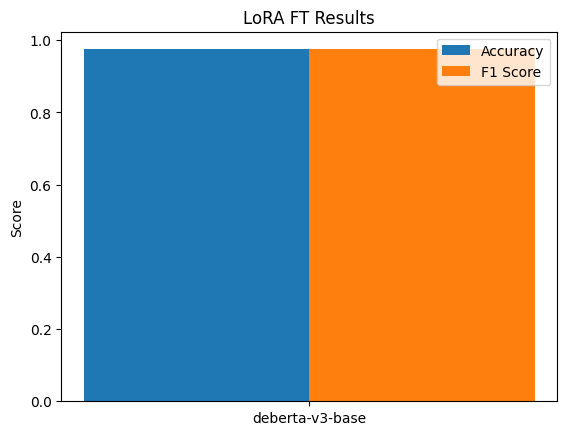

In [46]:
import matplotlib.pyplot as plt

models = ["deberta-v3-base"]

accuracy = metrics["eval_accuracy"]["accuracy"]
f1 = metrics["eval_f1"]["f1"]
x = range(len(models))
width = 0.2

plt.bar([i - width/2 for i in x], accuracy, width=width, label="Accuracy")
plt.bar([i + width/2 for i in x], f1, width=width, label="F1 Score")

plt.xticks(x, models)
plt.ylabel("Score")
plt.title("LoRA FT Results")
plt.legend()
plt.show()

#Saving Model + config + tokenizer

In [47]:
trainer.save_model("./deberta-v3-classifier")  # saves model + config
tokenizer.save_pretrained("./deberta-v3-classifier")  # saves tokenizer

('./deberta-v3-classifier/tokenizer_config.json',
 './deberta-v3-classifier/special_tokens_map.json',
 './deberta-v3-classifier/spm.model',
 './deberta-v3-classifier/added_tokens.json',
 './deberta-v3-classifier/tokenizer.json')

#Zip & Download

In [50]:
!zip -r deberta-v3-classifier.zip ./deberta-v3-classifier

  adding: deberta-v3-classifier/ (stored 0%)
  adding: deberta-v3-classifier/README.md (deflated 66%)
  adding: deberta-v3-classifier/training_args.bin (deflated 53%)
  adding: deberta-v3-classifier/spm.model (deflated 50%)
  adding: deberta-v3-classifier/adapter_model.safetensors (deflated 7%)
  adding: deberta-v3-classifier/tokenizer.json (deflated 77%)
  adding: deberta-v3-classifier/tokenizer_config.json (deflated 73%)
  adding: deberta-v3-classifier/added_tokens.json (stored 0%)
  adding: deberta-v3-classifier/special_tokens_map.json (deflated 50%)
  adding: deberta-v3-classifier/adapter_config.json (deflated 56%)
